# XG Boost

The aim of this notebook is to try out XG-boost on our optimization problem. There is also some ideas and concepts that will overlap with other machine learning models. Some novel ideas related to the preprocessing step is in this file, but SHOULD be moved to a dedicated pre-processing library to make the puipeline easier to work with.

*TODO: Create a preprocessing library*

### Import the needed libraries

In [2]:
# First we will extract the data, and save it to a csv.

import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb


### Extract data

In [3]:
train_a = pd.read_parquet('A/train_targets.parquet')
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')

print(X_train_estimated_a.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17576 entries, 0 to 17575
Data columns (total 47 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date_calc                       17576 non-null  datetime64[us]
 1   date_forecast                   17576 non-null  datetime64[us]
 2   absolute_humidity_2m:gm3        17576 non-null  float32       
 3   air_density_2m:kgm3             17576 non-null  float32       
 4   ceiling_height_agl:m            13657 non-null  float32       
 5   clear_sky_energy_1h:J           17576 non-null  float32       
 6   clear_sky_rad:W                 17576 non-null  float32       
 7   cloud_base_agl:m                15482 non-null  float32       
 8   dew_or_rime:idx                 17576 non-null  float32       
 9   dew_point_2m:K                  17576 non-null  float32       
 10  diffuse_rad:W                   17576 non-null  float32       
 11  di

### Preprocessing of data
Notice that we for now have a whole block dedicated to preprocessing, but should rather be its own module.

TODO: Only train on the daytime data.

TODO: Add a sun asimuth is good enough.

In [4]:
def data_length_matching(train: pd.DataFrame, obs: pd.DataFrame)-> tuple[pd.DataFrame, pd.DataFrame]:
    """
    This function is intended to ensure that both the training data and
    the observed data are sorted, and contain the same number of entries. 
    """

    # Cut the data frames so that their date match.
    obs_feature_test = obs[obs['date_forecast'].isin(train['time'])].sort_values(by=['date_forecast'])  # sortert etter datao
    # If only one of them has the date ensure that the other also has the same sorting.
    train_feature_test = train[train['time'].isin(obs['date_forecast'])].sort_values(by=['time'])       # sortert etter datao

    return train_feature_test, obs_feature_test

X_total = pd.concat([X_train_observed_a, X_train_estimated_a], axis = 0, ignore_index=True)

y, X = data_length_matching(train_a, X_total)
print(len(X))
print(len(y))


y = y.reset_index(drop = True)

X = X.reset_index(drop = True)
X['day_of_year'] = X['date_forecast'].dt.dayofyear

X = X.drop('date_forecast', axis=1)
X = X.drop('date_calc', axis=1)
X = X.interpolate(method='linear')
X = X.fillna(method="backfill", axis=None)
y = y.drop('time', axis=1)

sun_thres_idx = X['sun_elevation:d'][X['sun_elevation:d'] > 10].index.to_list()
X = X.loc[sun_thres_idx]
y = y.loc[sun_thres_idx]

print(y.info)
#X_best = SelectKBest(f_regression, k=6).fit_transform(X.values, y.values)


# Add a column for day of the year
# Add a column for day
# Retrieve each set of indexes

# Night-time, daytime predictor?

# DO we get a day or the 

xtrain, xtest, ytrain, ytest=train_test_split(X, y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()

# Fit and transform the data
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)



34061
34061


KeyError: "['index'] not found in axis"

## AI Training: GradientBoostingRegressor


In [ ]:

gbr = GradientBoostingRegressor(n_estimators=600, 
    max_depth=5, 
    learning_rate=0.01, 
    min_samples_split=3)


#+====================================================================================================================+
#| Additional idea: Notice that time of day parameters will probably be provided... Fitting this to a location might  |
#| give us an edge needed to fit a better algorithm for each location...                                              |
#+====================================================================================================================+

gbr.fit(xtrain, ytrain)
ypred = gbr.predict(xtest)
mse = mean_squared_error(np.array(ytest), np.array(ypred))

# Idea generate a reasonable estimate... This will be based on absolute max... 

x_ax = range(24)
plt.scatter(x_ax, ytest[0:24], s=5, color="blue", label="original")
plt.plot(x_ax, ypred[0:24], lw=0.8, color="red", label="predicted")

plt.legend()
plt.show()

print("The mean square error is", mse)
#240441.0648973231

# Change the optimization problem to predict how much deviance? There are more ... 
# Or preict a scalar?


ValueError: y should be a 1d array, got an array of shape (9627, 2) instead.

In [ ]:


# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Define the XGBoost model
xgb_model = xgb.XGBRegressor()

# Define a parameter grid to search through
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(xtrain, ytrain)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Train the model with the best hyperparameters
best_model = xgb.XGBRegressor(**best_params)
best_model.fit(xtrain, ytrain)

# Make predictions on the test set
ypred = best_model.predict(xtest)

# Evaluate the model
mse = mean_squared_error(ytest, ypred)
print("Mean Squared Error:", mse)



c:\Users\asber\anaconda3\envs\basic_machine_learning\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\asber\anaconda3\envs\basic_machine_learning\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
c:\Users\asber\anaconda3\envs\basic_machine_learning\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\asber\anaconda3\envs\basic_machine_learning\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a fu

KeyboardInterrupt: 

### Plotting
Adding a set of plotts to see how well the machine-learning model performs graphically.

TODO: We should probably plot the data-values that perform the worst.

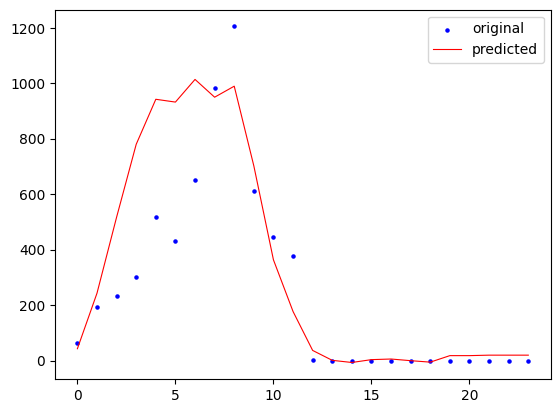

1417394.7392159498


In [ ]:


x_ax = range(24)
plt.scatter(x_ax, ytest[0:24], s=5, color="blue", label="original")
plt.plot(x_ax, ypred[0:24], lw=0.8, color="red", label="predicted")

plt.legend()
plt.show()
x = (np.array(ypred)-np.array(ytest))

print(np.mean(np.square(x)))